In [137]:
library(DBI)
library(RPostgres)
library(sf)
library(ggplot2)
library(dplyr)
library(readxl)
library(readr)
library(lubridate)
library(repr)
library(scales)
library(stringr)

options(repr.plot.width=20, repr.plot.height=10)
pg_pw_prod = Sys.getenv("AZURE_DB_PW_PROD")

# env keys set based creds stored in bitwarden
con <- DBI::dbConnect(
    drv = RPostgres::Postgres(),
    user = "chdadmin",
    host = "chd-rasterstats-prod.postgres.database.azure.com",
    password = pg_pw_prod,
    port = 5432,
    dbname = "postgres"
  )

In [86]:
base_map_theme <- theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title = element_blank(),
    panel.background = element_rect(fill = "white"),
    plot.background = element_rect(fill = "white", color = NA),
    plot.title = element_text(size = 20, face = "bold"),
    plot.subtitle = element_text(size = 16),
    legend.position = c(0.85, 0.95), 
    legend.justification = c(0, 1), 
    legend.box.just = "right",
    legend.key.size = unit(1.5, "cm"),
    legend.title = element_text(size = 12), 
    legend.text = element_text(size = 10), 
  )

base_graph_theme <- theme_minimal() + 
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
        axis.text.y = element_text(size = 8),
        axis.title = element_text(size = 16),
        strip.text = element_text(face = "bold"),
        panel.spacing = unit(0.25, "lines"),
        axis.text.y.right = element_blank(),
        axis.ticks.y.right = element_blank(),
        axis.title.y.right = element_blank(),
        panel.grid = element_blank(),
        legend.position = "bottom",
        panel.border = element_rect(color = "grey", fill = NA, size = 0.25),
        plot.title = element_text(size = 20, face = "bold"),
        plot.subtitle = element_text(size = 16)
      ) 

## 1. Cleaning 2024 PiN data

We need go get the total 2024 PiN values across all zones (ADM2) in Ethiopia, then subset by our best estimate of zones that experience the MAM season.

In [93]:
# Get the admin bounds
eth_adm2 <- st_read(
    file.path(
        Sys.getenv("AA_DATA_DIR"),
        "public", "raw", "eth", "cod_ab", "Admin_2024.gdb.zip"), 
    layer = "eth_admbnda_adm2_csa_bofedb_2024") %>%
    filter(!(admin2Pcode %in% list("ET0000", "ET1000")))

Reading layer `eth_admbnda_adm2_csa_bofedb_2024' from data source 
  `/Users/hannahker/Library/CloudStorage/GoogleDrive-hannah.ker@humdata.org/Shared drives/Data Science/CERF Anticipatory Action/General - All AA projects/Data/public/raw/eth/cod_ab/Admin_2024.gdb.zip' 
  using driver `OpenFileGDB'
Simple feature collection with 103 features and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 32.9918 ymin: 3.40667 xmax: 47.98824 ymax: 14.84548
Geodetic CRS:  WGS 84


In [18]:
# Get the PiN data and join with the geodataframe
df_pin <- read_excel(
    file.path(
        Sys.getenv("AA_DATA_DIR"),
        "public", "exploration", "eth", 
        "ethiopia-2024-humanitairan-needs-overview_hxl.xlsx"
    ),
    sheet = "Overall PIN"
)  %>% 
    slice(-1) %>% 
    mutate(`Overall PIN` = as.numeric(`Overall PIN`)) %>%
    group_by(admin2Pcode) %>%
    summarise(TotalPin = sum(`Overall PIN`, na.rm = TRUE)) %>%
    select("admin2Pcode", "TotalPin")

gdf_adm2 <- eth_adm2 %>%
    merge(df_pin, by="admin2Pcode", all.x=TRUE)

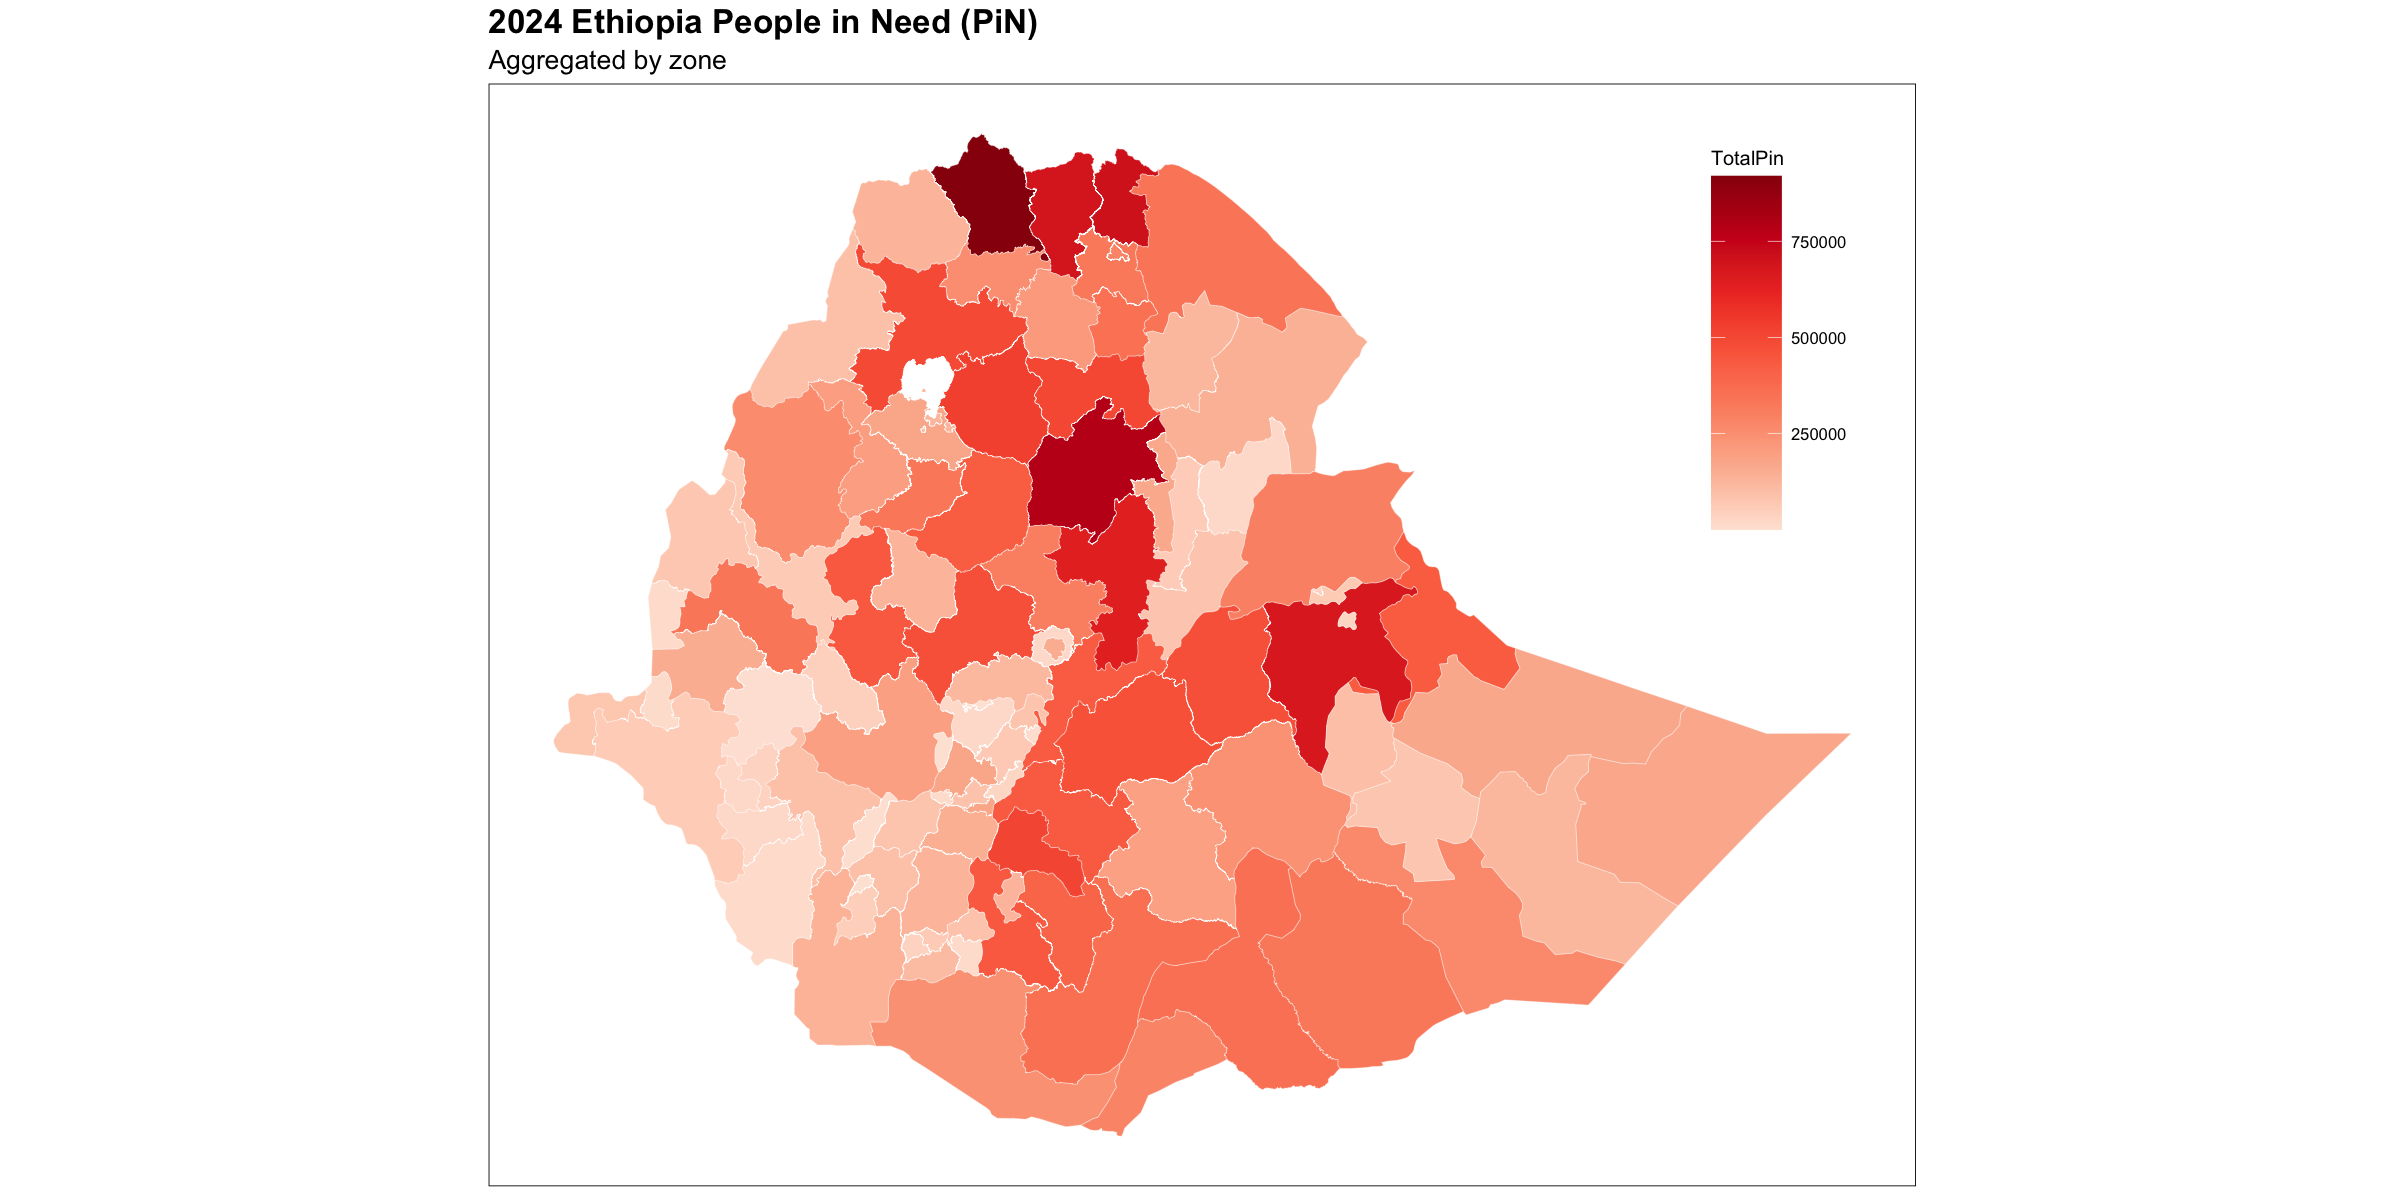

In [90]:
ggplot(data = gdf_adm2) +
  geom_sf(aes(fill = TotalPin), linewidth=0.1, color="white") +
  scale_fill_distiller(palette = "Reds", direction = 1) + 
  base_map_theme +
  labs(title = "2024 Ethiopia People in Need (PiN)",
       subtitle = "Aggregated by zone", 
       fill = "PiN")

In [21]:
# MAM and OND zones defined by FEWSNET
df_mam_ond <- read_csv(
    file.path(
        Sys.getenv("AA_DATA_DIR"),
        "public", "exploration", "eth", 
        "mam_ond_zones_fewsnet.csv"
    ),
    show_col_types=FALSE
)

# Also hard-code in some zones 
ond_zones <- list(
    "ET0508",
    "ET0806",
    "ET0808",
    "ET0411",
    "ET0412",
    "ET0810",
    "ET0511",
    "ET0807",
    "ET0507",
    "ET0421",
    "ET0410",
    "ET0504",
    "ET0502",
    "ET0802",
    "ET0414",
    "ET0503",
    "ET0809",
    "ET0505",
    "ET0509",
    "ET0510",
    "ET0506",
    "ET0812",
    "ET0415",
    "ET0422",
    "ET0408",
    "ET0417",
    "ET1600",
    "ET0811"
)

# Filter the gdf to only include the admin areas that experience ond/mam seasons
gdf_ond_mam <- gdf_adm2 %>%
    filter(
        admin2Pcode %in% df_mam_ond$admin2Pcode |
        admin2Pcode %in% ond_zones
    )

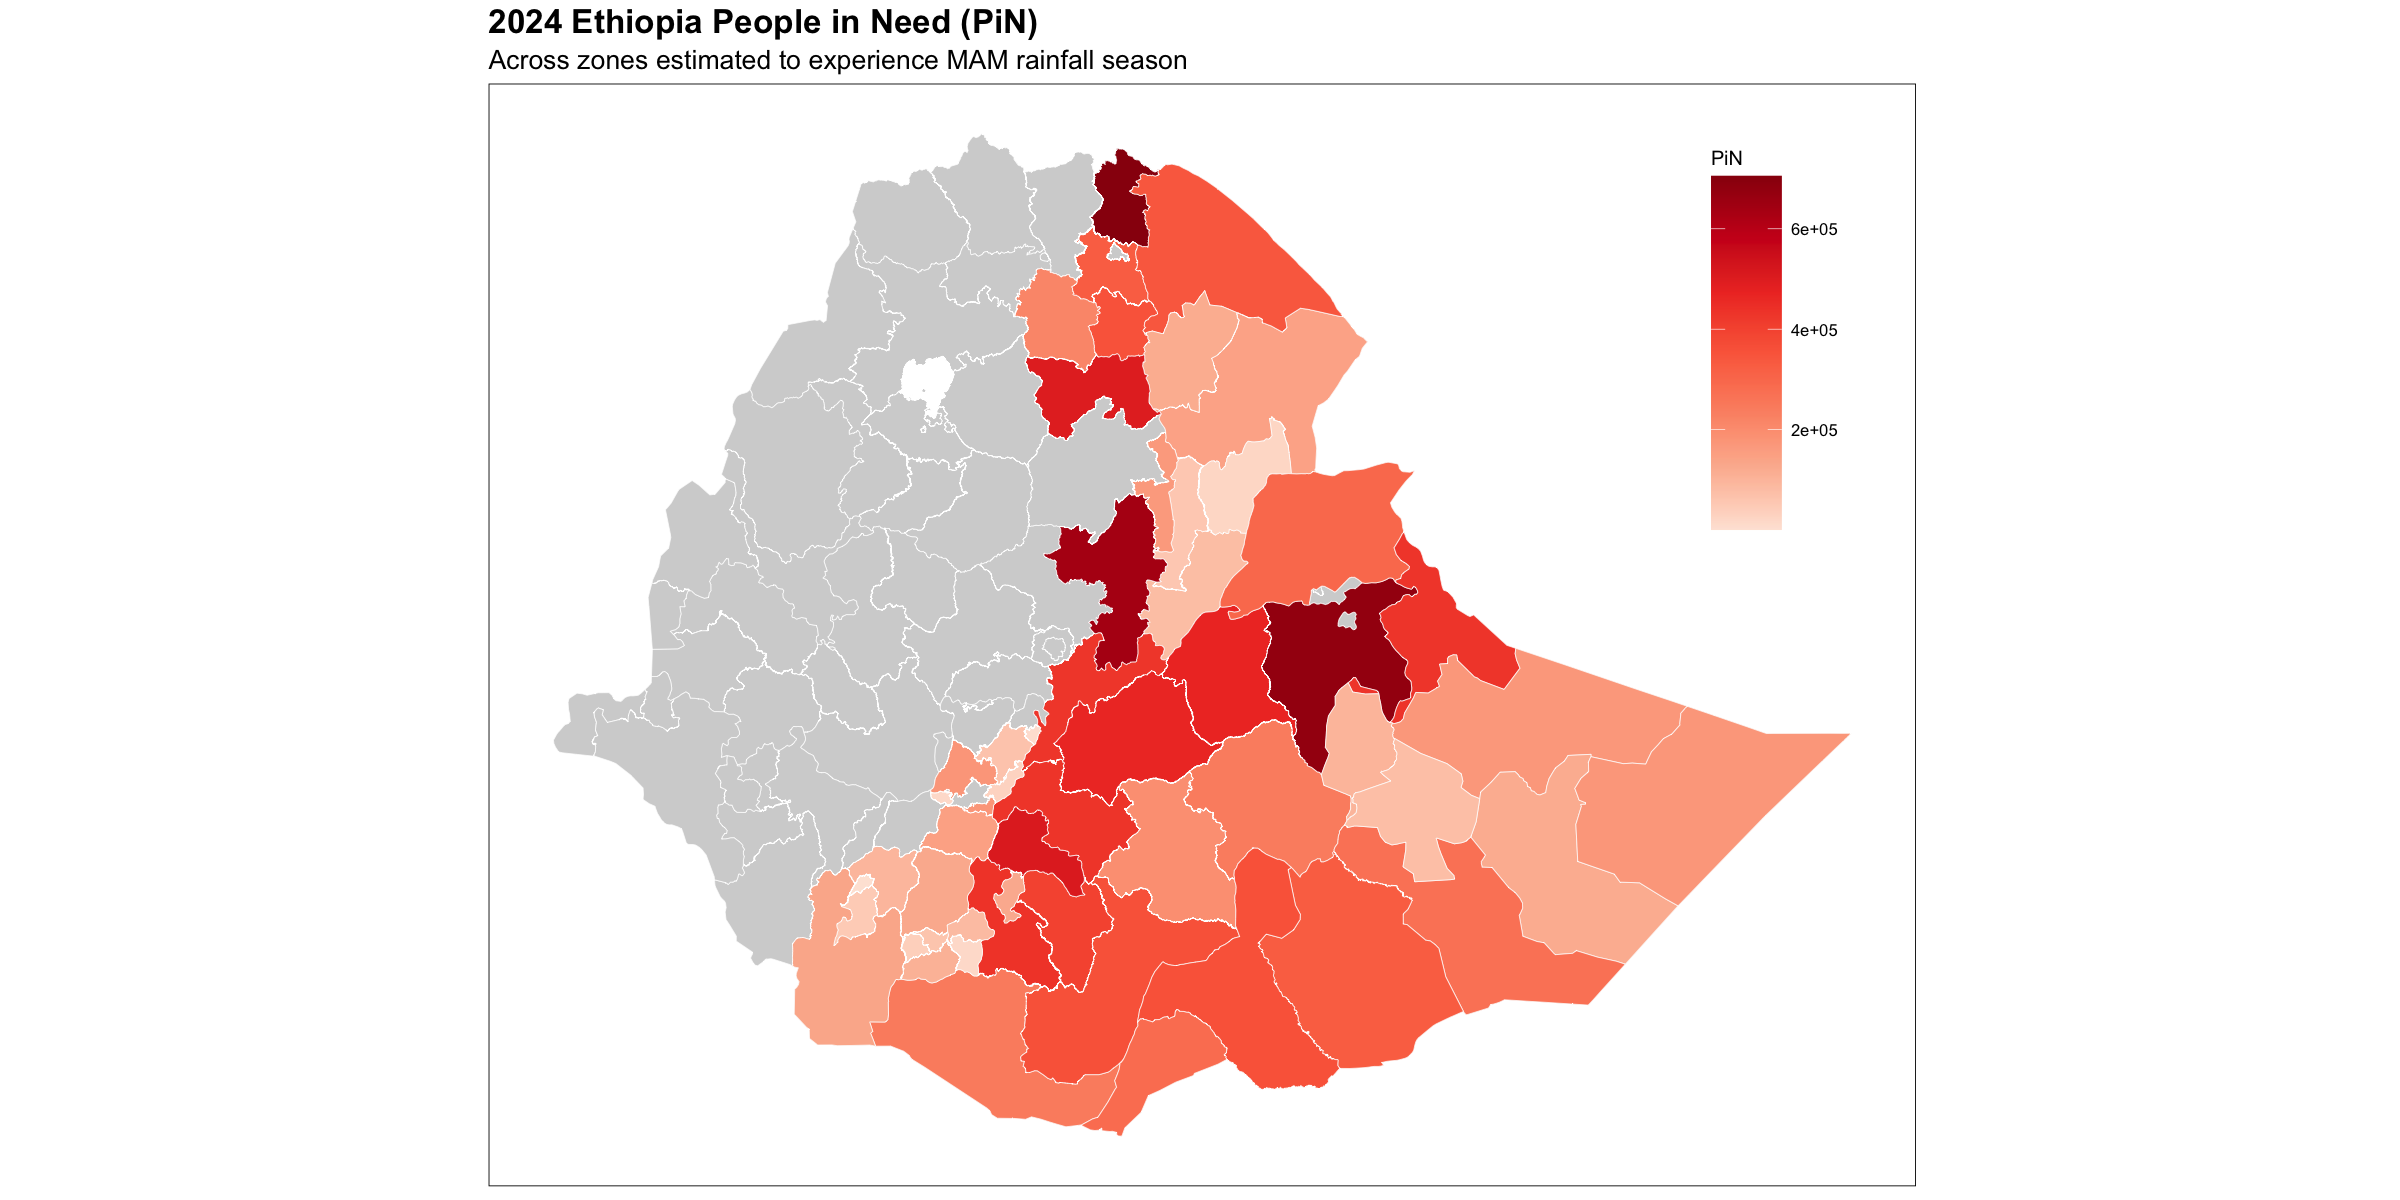

In [108]:
ggplot() +
    geom_sf(data = gdf_adm2, fill = "lightgrey", color = "white") +
    geom_sf(data = gdf_ond_mam, aes(fill = TotalPin), color = "white") +
    scale_fill_distiller(palette = "Reds", direction = 1) + 
    base_map_theme + 
    labs(title = "2024 Ethiopia People in Need (PiN)",
       subtitle = "Across zones estimated to experience MAM rainfall season",
       fill = "PiN")

ggsave("pin_targetted_zones.png", width = 30, height = 30, units = "cm")

## 2. Processing rainfall data

We can get Ethiopia's raster stats from the team's PostgreSQL database, where stats are pulled from the ECMWF ERA5 Reanalysis.

In [95]:
# Get the historical rainfall data from the database to selected zones
query_era5 <- "SELECT * from public.era5 WHERE iso3='ETH' AND adm_level=2"
df_era5 <- dbGetQuery(con, query_era5) %>%
    filter(
        pcode %in% df_mam_ond$admin2Pcode |
        pcode %in% ond_zones
    )

Now we'll:
- Filter by zones only in March/April/May
- Calculate the total average rainfall for the season across each zones, for each year
- Identify years that are in the lower tercile 

In [110]:
df_mam_by_zone <- df_era5_filtered %>% 
    mutate(year = year(valid_date), month = month(valid_date)) %>%
    # Specifically for ERA5 as values are monthly estimates for total daily precip
    mutate(mean = mean * 30) %>%
    filter(month %in% c(3, 4, 5)) %>%
    group_by(pcode, year) %>% 
    summarise(total_rainfall_mam = sum(mean, na.rm=TRUE)) %>%
    ungroup() %>%
    arrange(pcode, year) %>%
    mutate(year = as.numeric(year)) %>%
    group_by(pcode) %>%
    mutate(
        tercile = ntile(total_rainfall_mam, 3),
        is_lower_tercile = tercile == 1
        ) %>%
    ungroup()

`summarise()` has grouped output by 'pcode'. You can override using the `.groups` argument.


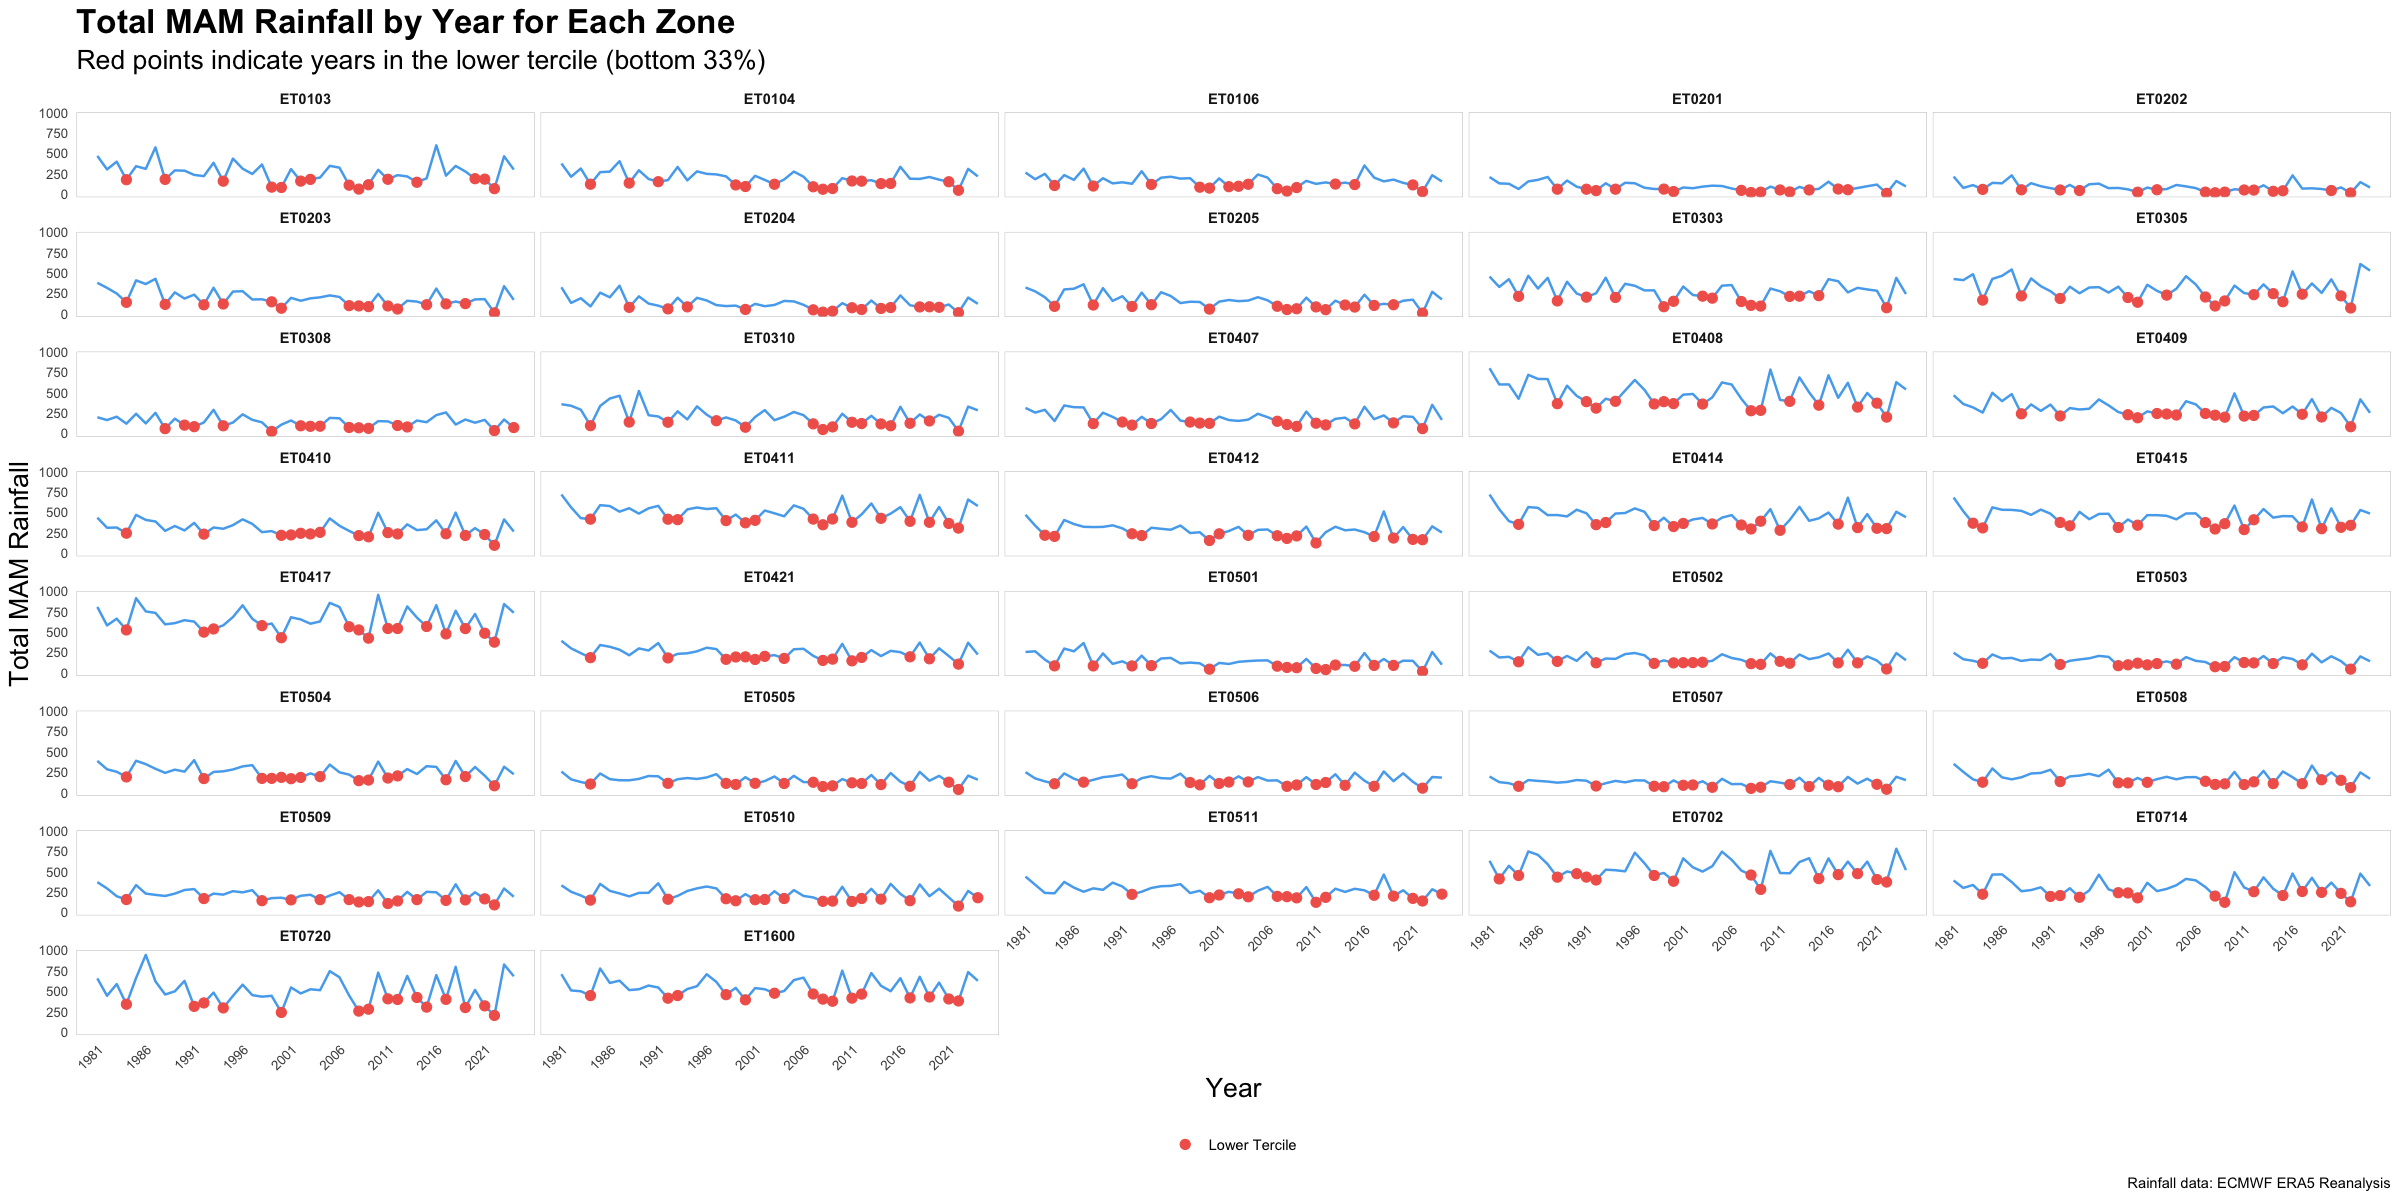

In [111]:
ggplot(df_mam_by_zone, aes(x = year, y = total_rainfall_mam, group = pcode)) +
  geom_line(color = "#55ACEE", size = 0.7) +
  geom_point(data = filter(df_mam_by_zone, is_lower_tercile), 
             aes(color = "Lower Tercile"), size = 2.5) +
  scale_color_manual(values = c("Lower Tercile" = "#F2645A")) +
  facet_wrap(~ pcode, scales = "fixed", ncol = 5) +
  base_graph_theme +
  labs(
    title = "Total MAM Rainfall by Year for Each Zone",
    subtitle = "Red points indicate years in the lower tercile (bottom 33%)",
    x = "Year",
    y = "Total MAM Rainfall",
    caption = "Rainfall data: ECMWF ERA5 Reanalysis",
    color = NULL
  ) +
  scale_x_continuous(breaks = seq(min(df_mam_by_zone$year), max(df_mam_by_zone$year), by = 5))

ggsave("total_rainfall_by_zone.png", width = 40, height = 25, units = "cm")

## 3. Joining PiN and total rainfall

Only keep the PiN values for years that are in the lower tercile, and then sum the total PiN for each year.

In [112]:
gdf_pin <- gdf_ond_mam %>%
    select("admin2Pcode", "admin2Name_en", "TotalPin", "geometry")

In [113]:
gdf_merged <- df_mam_by_zone %>%
    left_join(gdf_pin, by = c("pcode" = "admin2Pcode")) %>%
    mutate(TotalPin = if_else(is_lower_tercile == FALSE, 0, TotalPin)) 

In [131]:
df_pin_mam <- gdf_merged %>% 
    group_by(year) %>% 
    summarise(
        total_pin = sum(TotalPin, na.rm=TRUE),
        affected_zones = paste(pcode[TotalPin != 0], collapse = ", ")
    ) %>%
    ungroup() %>%
    arrange(year)

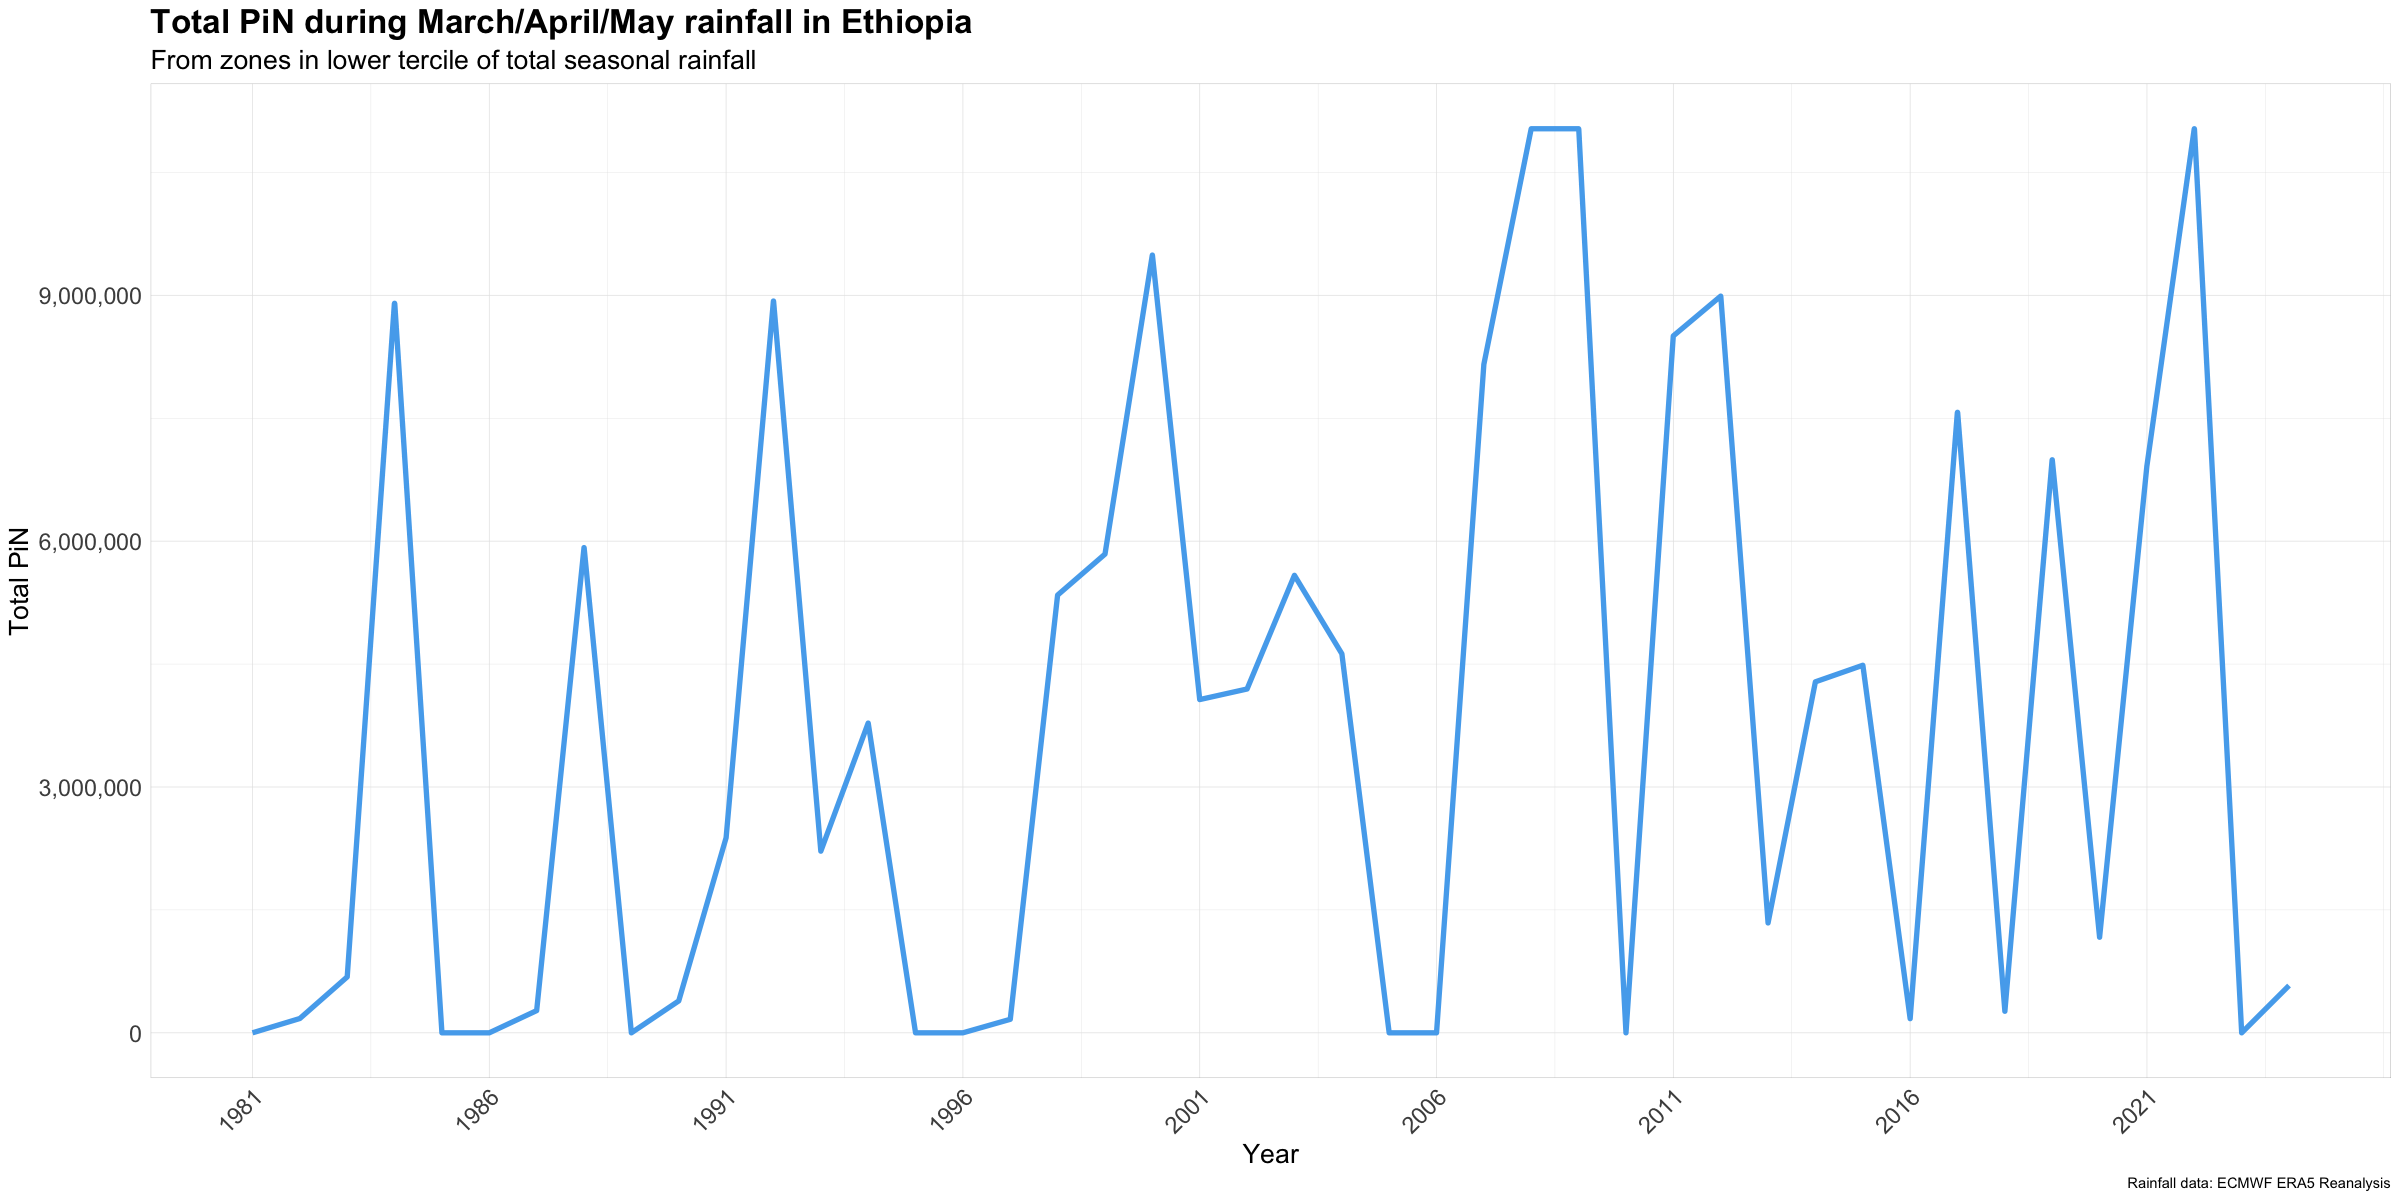

In [189]:
ggplot(df_pin_mam, aes(x=year, y=total_pin)) + 
    geom_line(color = "#55ACEE", size = 1.5) +
    # TODO: This is pretty manual...
    # geom_point(x=2012, y=8990095.8, size=5, color="#F2645A") +
    scale_x_continuous(breaks = seq(min(df_pin_mam$year), max(df_pin_mam$year), by = 5)) +
    scale_y_continuous(labels = comma_format(big.mark = ",")) +
    base_graph_theme + 
    theme(
        axis.text.x = element_text(size = 14),
        axis.text.y = element_text(size = 14),
        panel.grid.major = element_line(color = "grey90", linewidth = 0.2),
        panel.grid.minor = element_line(color = "grey90", linewidth = 0.1),
    ) +
  labs(
    title = "Total PiN during March/April/May rainfall in Ethiopia",
    subtitle = "From zones in lower tercile of total seasonal rainfall",
    caption = "Rainfall data: ECMWF ERA5 Reanalysis",
    x = "Year",
    y = "Total PiN",
  ) 

# ggsave("total_pin.png", width = 30, height = 10, units = "cm")

## 4. Identifying the worst years

Now rank all years and create a map of all zones

In [134]:
df_sorted <- df_pin_mam %>% arrange(desc(total_pin))

In [182]:
create_yearly_map <- function(df, sf_zones, selected_year) {
  year_data <- df %>% 
    filter(year == selected_year)
  
  affected_zones <- str_split(year_data$affected_zones, ", ")[[1]]

  affected_sf <- sf_zones %>%
    filter(admin2Pcode %in% affected_zones)
  
  ggplot() +
    geom_sf(data = sf_zones, fill = "white", color = "gray") +
    geom_sf(data = gdf_ond_mam, fill = "lightgrey", color = "gray") +
    geom_sf(data = affected_sf, fill = "#F2645A", alpha = 1) +
    theme_minimal() +
    labs(title = paste("Affected Zones in", selected_year),
         subtitle = paste("Total PIN:", year_data$total_pin)) +
    scale_fill_manual(
        values = c("lightgrey", "#F2645A"),
        labels = c("Potential zones in season", "Zones in lower tercile of seasonal rainfall"),
        name = "Zone Status"
    ) +
    theme(
      legend.position = "bottom",
      legend.box = "horizontal"
    )
}

In [250]:
create_yearly_map <- function(df_yearly_pin, gdf_ond_mam, gdf_adm2, selected_year) {
    df_yearly_pin <- df_yearly_pin %>% 
        filter(year == selected_year)
    
    affected_zones <- str_split(df_yearly_pin$affected_zones, ", ")[[1]]

    sf_all_zones <- gdf_adm2 %>%
        mutate(status = case_when(
          admin2Pcode %in% affected_zones ~ "Zones in lower tercile of seasonal rainfall",
          admin2Pcode %in% gdf_ond_mam$admin2Pcode ~ "Potential zones in season",
          TRUE ~ "Other zones"
        ))
      
      ggplot() +
        geom_sf(data = sf_all_zones, aes(fill = status), color = "gray") +

        labs(title = paste("Affected Zones in", selected_year),
        #subtitle = paste("Total PIN:", year_data$total_pin),
        fill = "Zone Status") +
        scale_fill_manual(
          values = c("white", "lightgrey", "#F2645A"),
          labels = c("Other zones", "Potential zones in season", "Zones in lower tercile of seasonal rainfall"),
          name = "Zone Status"
        ) +
    base_map_theme +
        theme(
          legend.position = "bottom",
          legend.box = "horizontal"
        ) 
    ggsave(paste0("targeted_", selected_year, ".png"), width = 30, height = 30, units = "cm")
}

In [256]:
create_yearly_map(df_pin_mam, gdf_ond_mam, gdf_adm2, 2012)